In [22]:
from probcal.evaluation.calibration_evaluator import CalibrationResults
from probcal.models import GaussianNN, FaithfulGaussianNN
from probcal.data_modules import RotatedMNISTDataModule
from properscoring import crps_gaussian

import torch
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

In [6]:
dm = RotatedMNISTDataModule("data/rotated-mnist", batch_size=512, num_workers=20, persistent_workers=True)
dm.prepare_data()
dm.setup("")

seitzer_results = CalibrationResults.load("results/rotated-mnist/seitzer/calibration_results.pt")
stirn_results = CalibrationResults.load("results/rotated-mnist/stirn/calibration_results.pt")

seitzer = GaussianNN.load_from_checkpoint("chkp/rotated-mnist/seitzer/version_0/best_loss.ckpt")
stirn = FaithfulGaussianNN.load_from_checkpoint("chkp/rotated-mnist/stirn/version_0/best_loss.ckpt")

In [9]:
device = torch.device("cuda")

seitzer = seitzer.to(device)
stirn = stirn.to(device)

In [36]:
# 1. Compute pointwise metrics on test set.

nll_vals = {"seitzer": [], "stirn": []}
crps_vals = {"seitzer": [], "stirn": []}
mae_vals = {"seitzer": [], "stirn": []}
var_vals = {"seitzer": [], "stirn": []}

with torch.inference_mode():
    for images, labels in dm.test_dataloader():
        images, labels = images.to(device), labels.to(device)

        for name, model in zip(("seitzer", "stirn"), (seitzer, stirn)):
            pred = model.predict(images)
            pred_dist = model.predictive_dist(pred)
            var = pred_dist.variance.detach().cpu()
            var_vals[name].append(var)
            mae_vals[name].append((labels.flatten() - pred_dist.mean.flatten()).abs().detach().cpu())
            crps_vals[name].append(
                crps_gaussian(
                    labels.flatten().detach().cpu(),
                    pred_dist.mean.flatten().detach().cpu(),
                    pred_dist.variance.sqrt().flatten().detach().cpu(),
                )
            )
            nll_vals[name].append(
                -pred_dist.log_prob(labels.flatten()).detach().cpu()
            )

    for metrics_dict in nll_vals, mae_vals, crps_vals, var_vals:
        for k in metrics_dict:
            metrics_dict[k] = np.concatenate(metrics_dict[k])

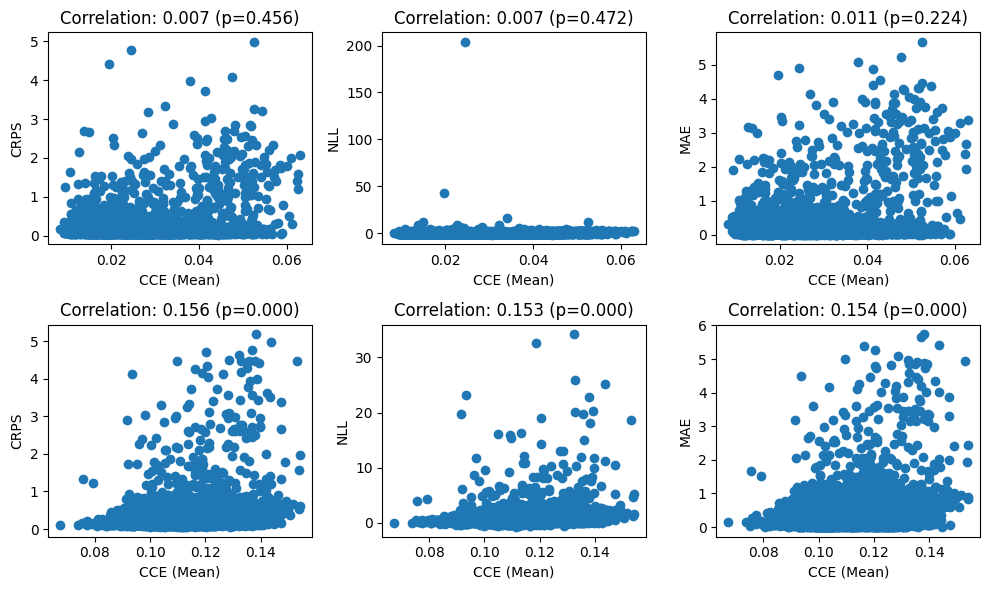

In [48]:
fig, axs = plt.subplots(2, 3, figsize=(10, 6))
for j, (metrics_dict, metric_name) in enumerate(zip((crps_vals, nll_vals, mae_vals), ("CRPS", "NLL", "MAE"))):
    for i, (calib_results, name) in enumerate(zip((seitzer_results, stirn_results), ("seitzer", "stirn"))):
        x = calib_results.cce.expected_values
        y = metrics_dict[name]
        axs[i, j].scatter(x, y)
        axs[i, j].set_xlabel("CCE (Mean)")
        axs[i, j].set_ylabel(metric_name)
        correlation = stats.kendalltau(x, y)
        axs[i, j].set_title(f"Correlation: {correlation.statistic:.3f} (p={correlation.pvalue:.3f})")
fig.tight_layout()
plt.show()

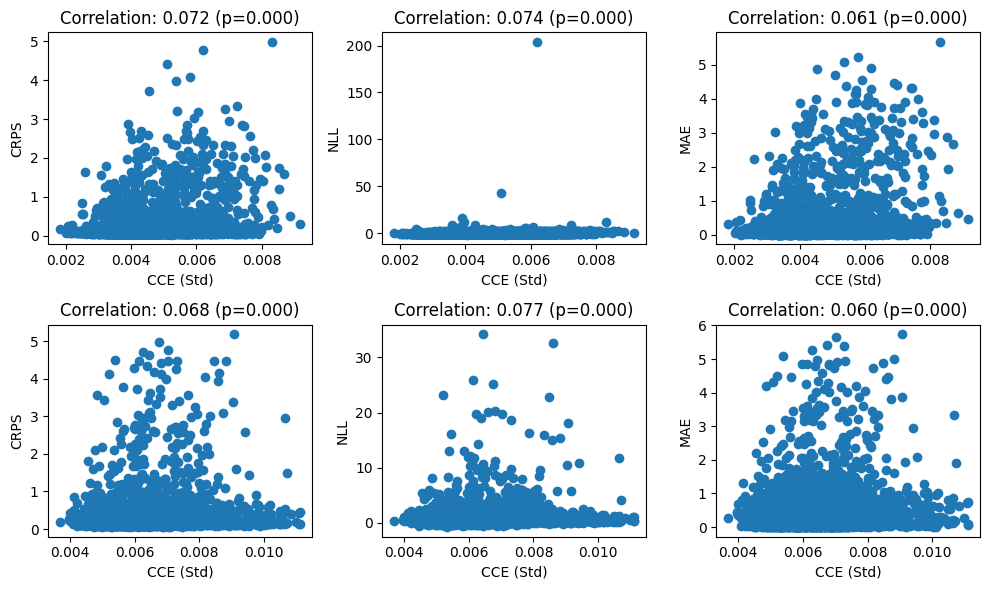

In [47]:
fig, axs = plt.subplots(2, 3, figsize=(10, 6))
for j, (metrics_dict, metric_name) in enumerate(zip((crps_vals, nll_vals, mae_vals), ("CRPS", "NLL", "MAE"))):
    for i, (calib_results, name) in enumerate(zip((seitzer_results, stirn_results), ("seitzer", "stirn"))):
        x = calib_results.cce.stdevs
        y = metrics_dict[name]
        axs[i, j].scatter(x, y)
        axs[i, j].set_xlabel("CCE (Std)")
        axs[i, j].set_ylabel(metric_name)
        correlation = stats.kendalltau(x, y)
        axs[i, j].set_title(f"Correlation: {correlation.statistic:.3f} (p={correlation.pvalue:.3f})")
fig.tight_layout()
plt.show()

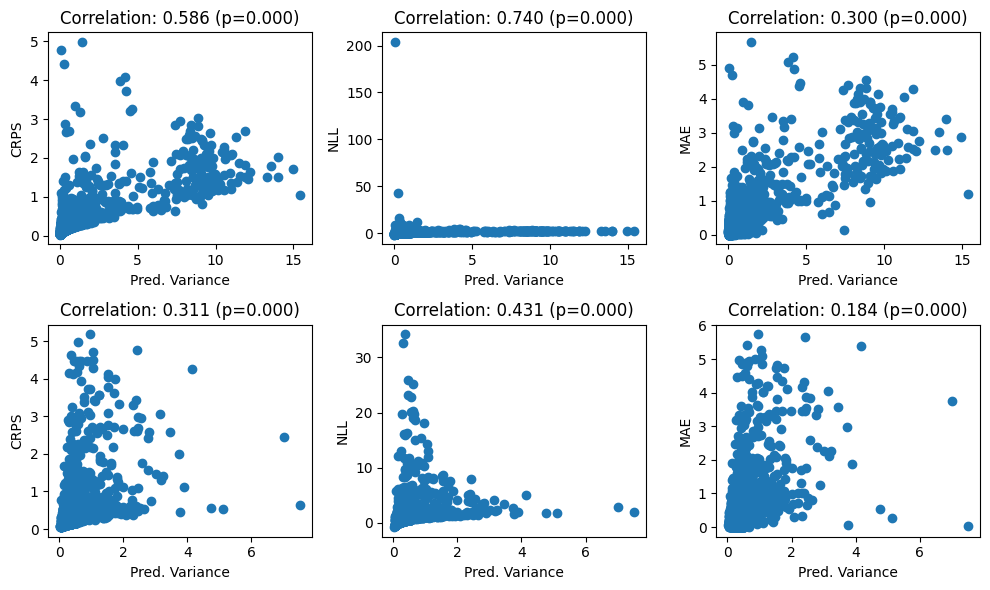

In [44]:
fig, axs = plt.subplots(2, 3, figsize=(10, 6))
for j, (metrics_dict, metric_name) in enumerate(zip((crps_vals, nll_vals, mae_vals), ("CRPS", "NLL", "MAE"))):
    for i, (calib_results, name) in enumerate(zip((seitzer_results, stirn_results), ("seitzer", "stirn"))):
        x = var_vals[name]
        y = metrics_dict[name]
        axs[i, j].scatter(x, y)
        axs[i, j].set_xlabel("Pred. Variance")
        axs[i, j].set_ylabel(metric_name)
        correlation = stats.kendalltau(x, y)
        axs[i, j].set_title(f"Correlation: {correlation.statistic:.3f} (p={correlation.pvalue:.3f})")
fig.tight_layout()
plt.show()